# Probability of Failure Estimation with Gaussian Processes

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats
import gpytorch
import torch
import os
import warnings
import pandas as pd
from gpytorch.utils.warnings import NumericalWarning
warnings.filterwarnings("ignore")
pd.set_option(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', 1000,
    'display.colheader_justify', 'center',
    'display.precision',2,
    'display.float_format',lambda x:'%.1e'%x)
from matplotlib import pyplot,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
pyplot.rcParams['font.size'] = 25
pyplot.rcParams['legend.fontsize'] = 25
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 10

In [2]:
gpytorch_use_gpu = torch.cuda.is_available()
gpytorch_use_gpu

False

## Method Visual

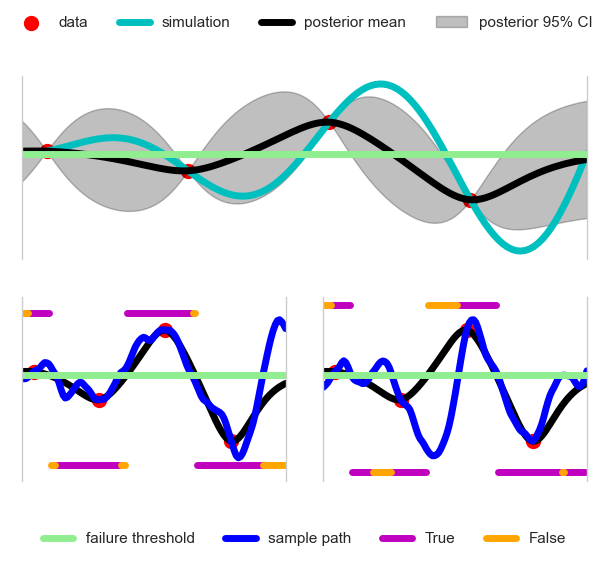

In [3]:
cols = 2
nticks = 129
np.random.seed(7); torch.manual_seed(1)
ci_percentage = .95
beta = scipy.stats.norm.ppf(np.mean([ci_percentage,1]))

f = lambda x: x*np.sin(4*np.pi*x)
x = qp.Lattice(1,seed=7).gen_samples(4).squeeze()
y = f(x)

gp = qp.util.ExactGPyTorchRegressionModel(
    x_t = x[:,None],
    y_t = y,
    prior_mean = gpytorch.means.ZeroMean(),
    prior_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)),
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8))) 
gp.fit(
    optimizer = torch.optim.Adam(gp.parameters(),lr=0.1),
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood,gp),
    training_iter = 100)

xticks = np.linspace(0,1,nticks)
yticks = f(xticks)
yhatticks_mean,yhatticks_std = gp.predict(xticks[:,None])
f_preds = gp(torch.from_numpy(xticks[:,None]))
f_samples = f_preds.sample(sample_shape=torch.Size((cols,))).numpy()

fig = pyplot.figure(tight_layout=True)
gs = gridspec.GridSpec(2,cols)
ax_top = fig.add_subplot(gs[0,:])
scatter_data = ax_top.scatter(x,y,color='r')
plot_yticks, = ax_top.plot(xticks,yticks,color='c')
plot_post_mean, = ax_top.plot(xticks,yhatticks_mean,color='k')
plot_gp_ci = ax_top.fill_between(xticks,yhatticks_mean+beta*yhatticks_std,yhatticks_mean-beta*yhatticks_std,color='k',alpha=.25)
ax_top.axhline(y=0,color='lightgreen')
for spine in ['top','bottom']: ax_top.spines[spine].set_visible(False)
ax_top.set_xlim([0,1]); ax_top.set_xticks([]); ax_top.set_yticks([])
for c in range(cols):
    f_sample = f_samples[c]
    ax = fig.add_subplot(gs[1,c]) if c==0 else fig.add_subplot(gs[1,c],sharey=ax)
    ax.scatter(x,y,color='r')
    ax.plot(xticks,yhatticks_mean,color='k')
    ax.set_xlim([0,1]); ax.set_xticks([])
    plot_draw, = ax.plot(xticks,f_sample,c='b')
    ymin,ymax = ax.get_ylim()#; ax.set_aspect(1/(ymax-ymin))
    yminticks,ymaxticks = np.tile(ymin,nticks),np.tile(ymax,nticks)
    tp = (f_sample>=0)*(yhatticks_mean>=0)
    tn = (f_sample<0)*(yhatticks_mean<0)
    fp = (f_sample<0)*(yhatticks_mean>=0)
    fn = (f_sample>=0)*(yhatticks_mean<0)
    plot_tp, = ax.plot(xticks,np.ma.masked_where(~tp,ymaxticks),color='m',linewidth=5)
    plot_fp, = ax.plot(xticks,np.ma.masked_where(~fp,ymaxticks),color='orange',linewidth=5)
    plot_tn, = ax.plot(xticks,np.ma.masked_where(~tn,yminticks),color='m',linewidth=5)
    plot_fn, = ax.plot(xticks,np.ma.masked_where(~fn,yminticks),color='orange',linewidth=5)
    ax.set_ylim([ymin-(ymax-ymin)*.05,ymax+(ymax-ymin)*.05])
    for spine in ['top','bottom']: ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    plot_failure_threshold = ax.axhline(y=0,color='lightgreen')
fig.legend([scatter_data,plot_yticks,plot_post_mean,plot_gp_ci],
           ['data','simulation','posterior mean','posterior 95% CI'],
           ncol=4,
           frameon=False,
           loc='upper center',
           bbox_to_anchor=(.5,1.075),
           prop={'size':11})
fig.legend([plot_failure_threshold,plot_draw,plot_tp,plot_fp,],
           ['failure threshold','sample path','True','False'],
           ncol=5,
           frameon=False,
           loc='upper center',
           bbox_to_anchor=(.5,0),#.58),
           prop={'size':11})
fig.savefig("outputs/TP_FP_TN_FN.png",dpi=256,transparent=True,bbox_inches="tight")

## Sin 1d Problem

reference approximation with d=1: 0.5000002384185791
batch 0
	gpytorch model fitting
		iter 50  of 100
			likelihood.noise_covar.raw_noise.................. -8.37e-02
			covar_module.raw_outputscale...................... -3.03e+00
			covar_module.base_kernel.raw_lengthscale.......... 5.02e+00
		iter 100 of 100
			likelihood.noise_covar.raw_noise.................. -9.22e-02
			covar_module.raw_outputscale...................... -2.96e+00
			covar_module.base_kernel.raw_lengthscale.......... 6.27e+00
batch 1
	AR sampling with efficiency 2.8e-01, expect 14 draws: 12, 15, 18, 21, 24, 
batch 2
	AR sampling with efficiency 1.7e-01, expect 23 draws: 16, 24, 28, 
batch 3
	AR sampling with efficiency 9.4e-02, expect 42 draws: 28, 
batch 4
	AR sampling with efficiency 6.0e-02, expect 66 draws: 48, 72, 
PFGPCIData (Data)
    solution        0.501
    error_bound     0.111
    bound_low       0.390
    bound_high      0.611
    n_total         20
    time_integrate  0.363
PFGPCI (AbstractStoppingCr

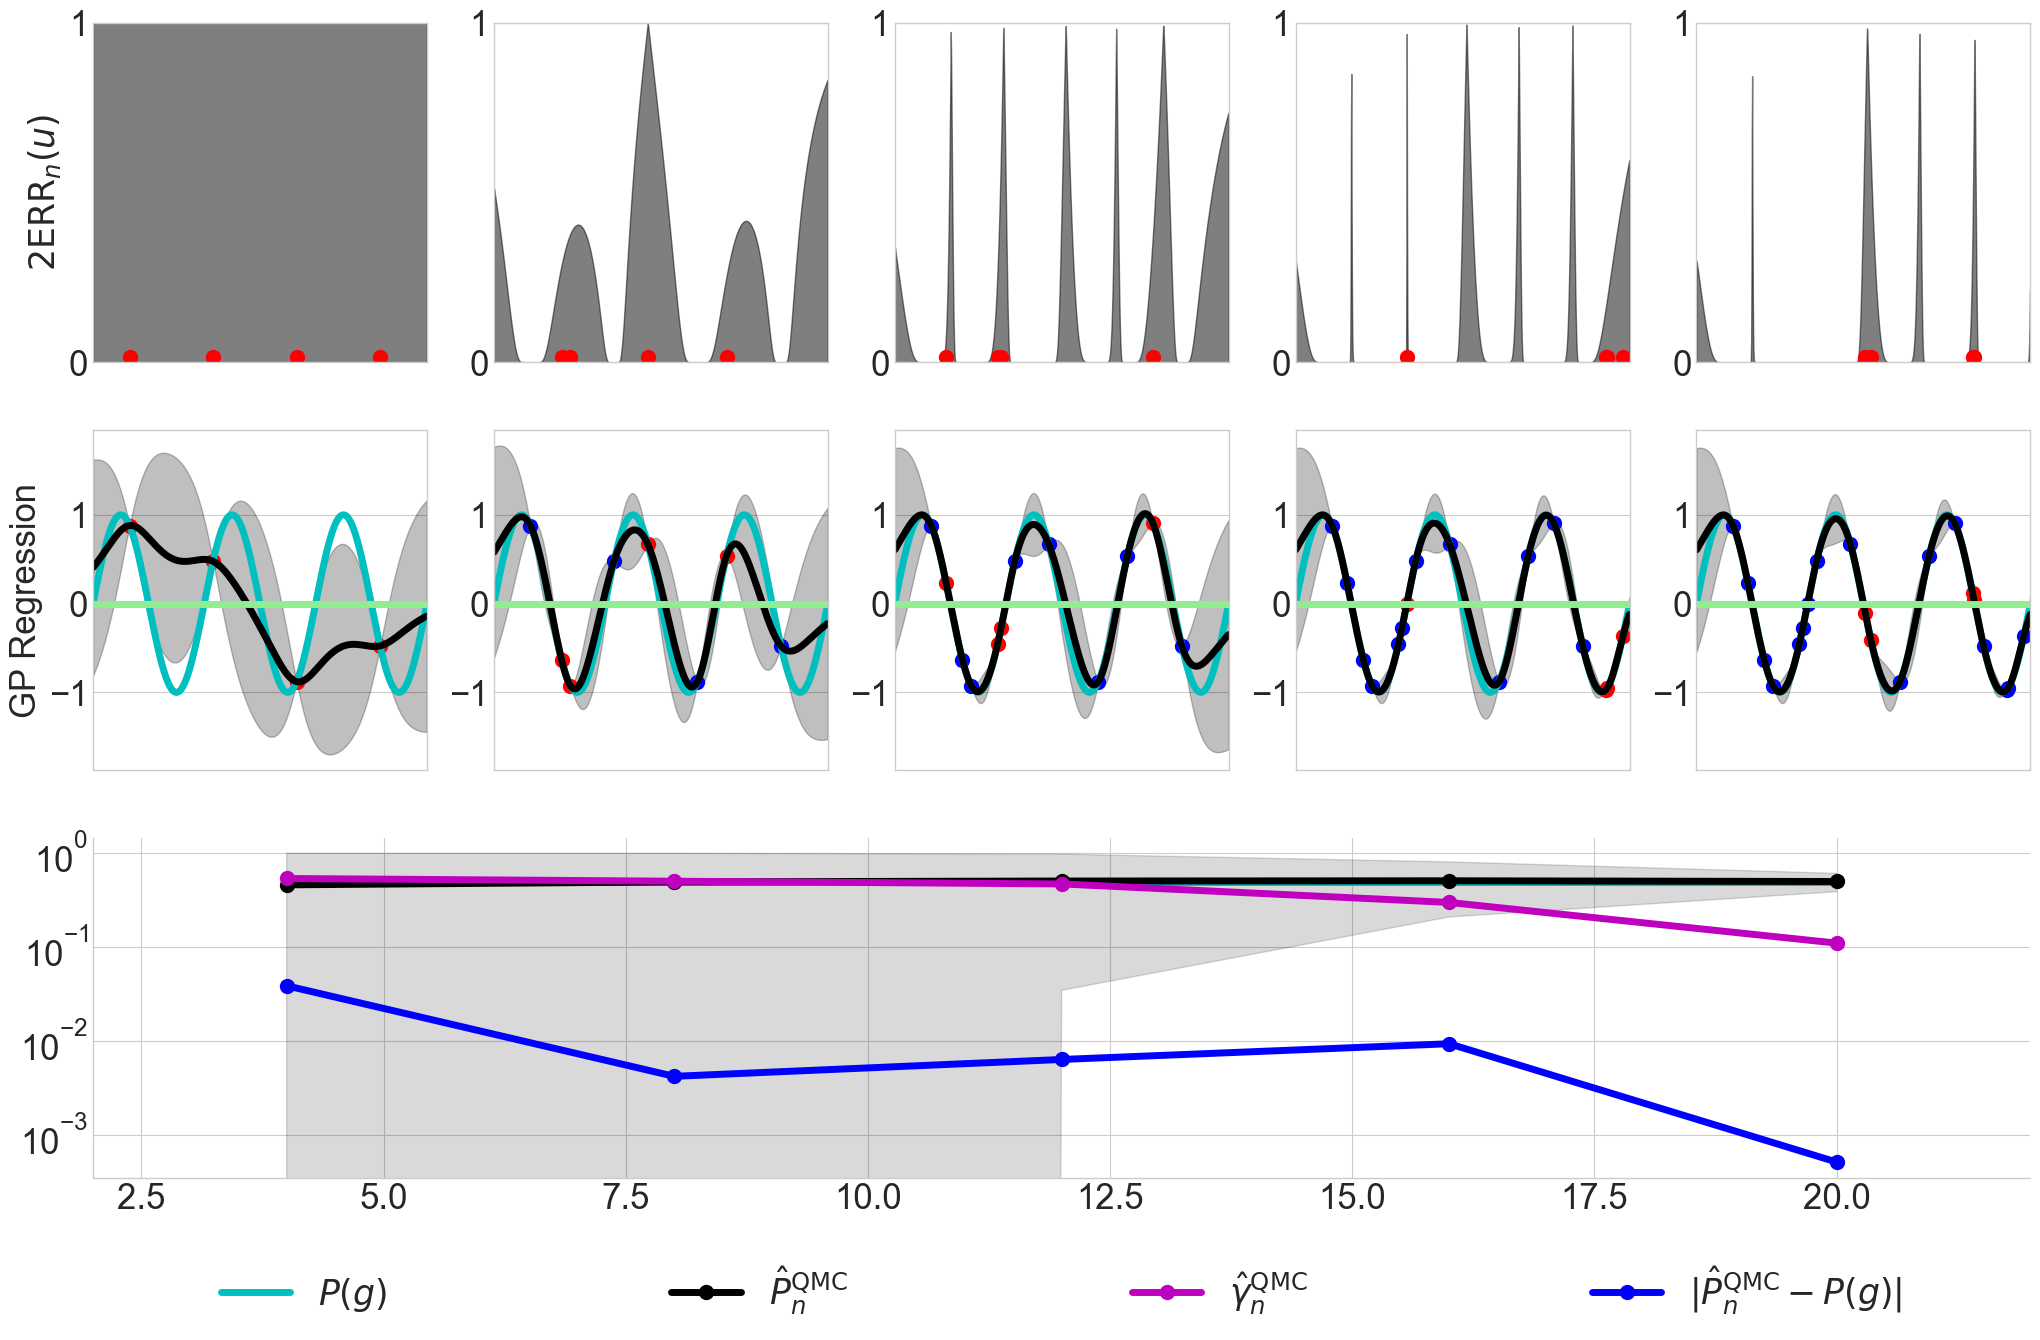

In [4]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Sin1d(qp.DigitalNetB2(1,seed=17),k=3),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 4,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 4,
    n_limit = 20,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.01,.1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,10)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 100,
    gpytorch_use_gpu = False,
    verbose = 50,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("outputs/Sin1D_df.csv",index=False)
fig.savefig("outputs/Sin1D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Multimodal 2d Problem

reference approximation with d=2: 0.30207324028015137
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 1.45e+00
			covar_module.raw_outputscale...................... 2.79e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.02e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 1.48e+00
			covar_module.raw_outputscale...................... 3.54e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.33e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 1.52e+00
			covar_module.raw_outputscale...................... 4.07e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.46e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 1.56e+00
			covar_module.raw_outputscale...................... 4.48e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.51e+00
batch 1
	AR sampling with efficiency 4.9e-02, expect 323 draws: 224, 364, 392, 406

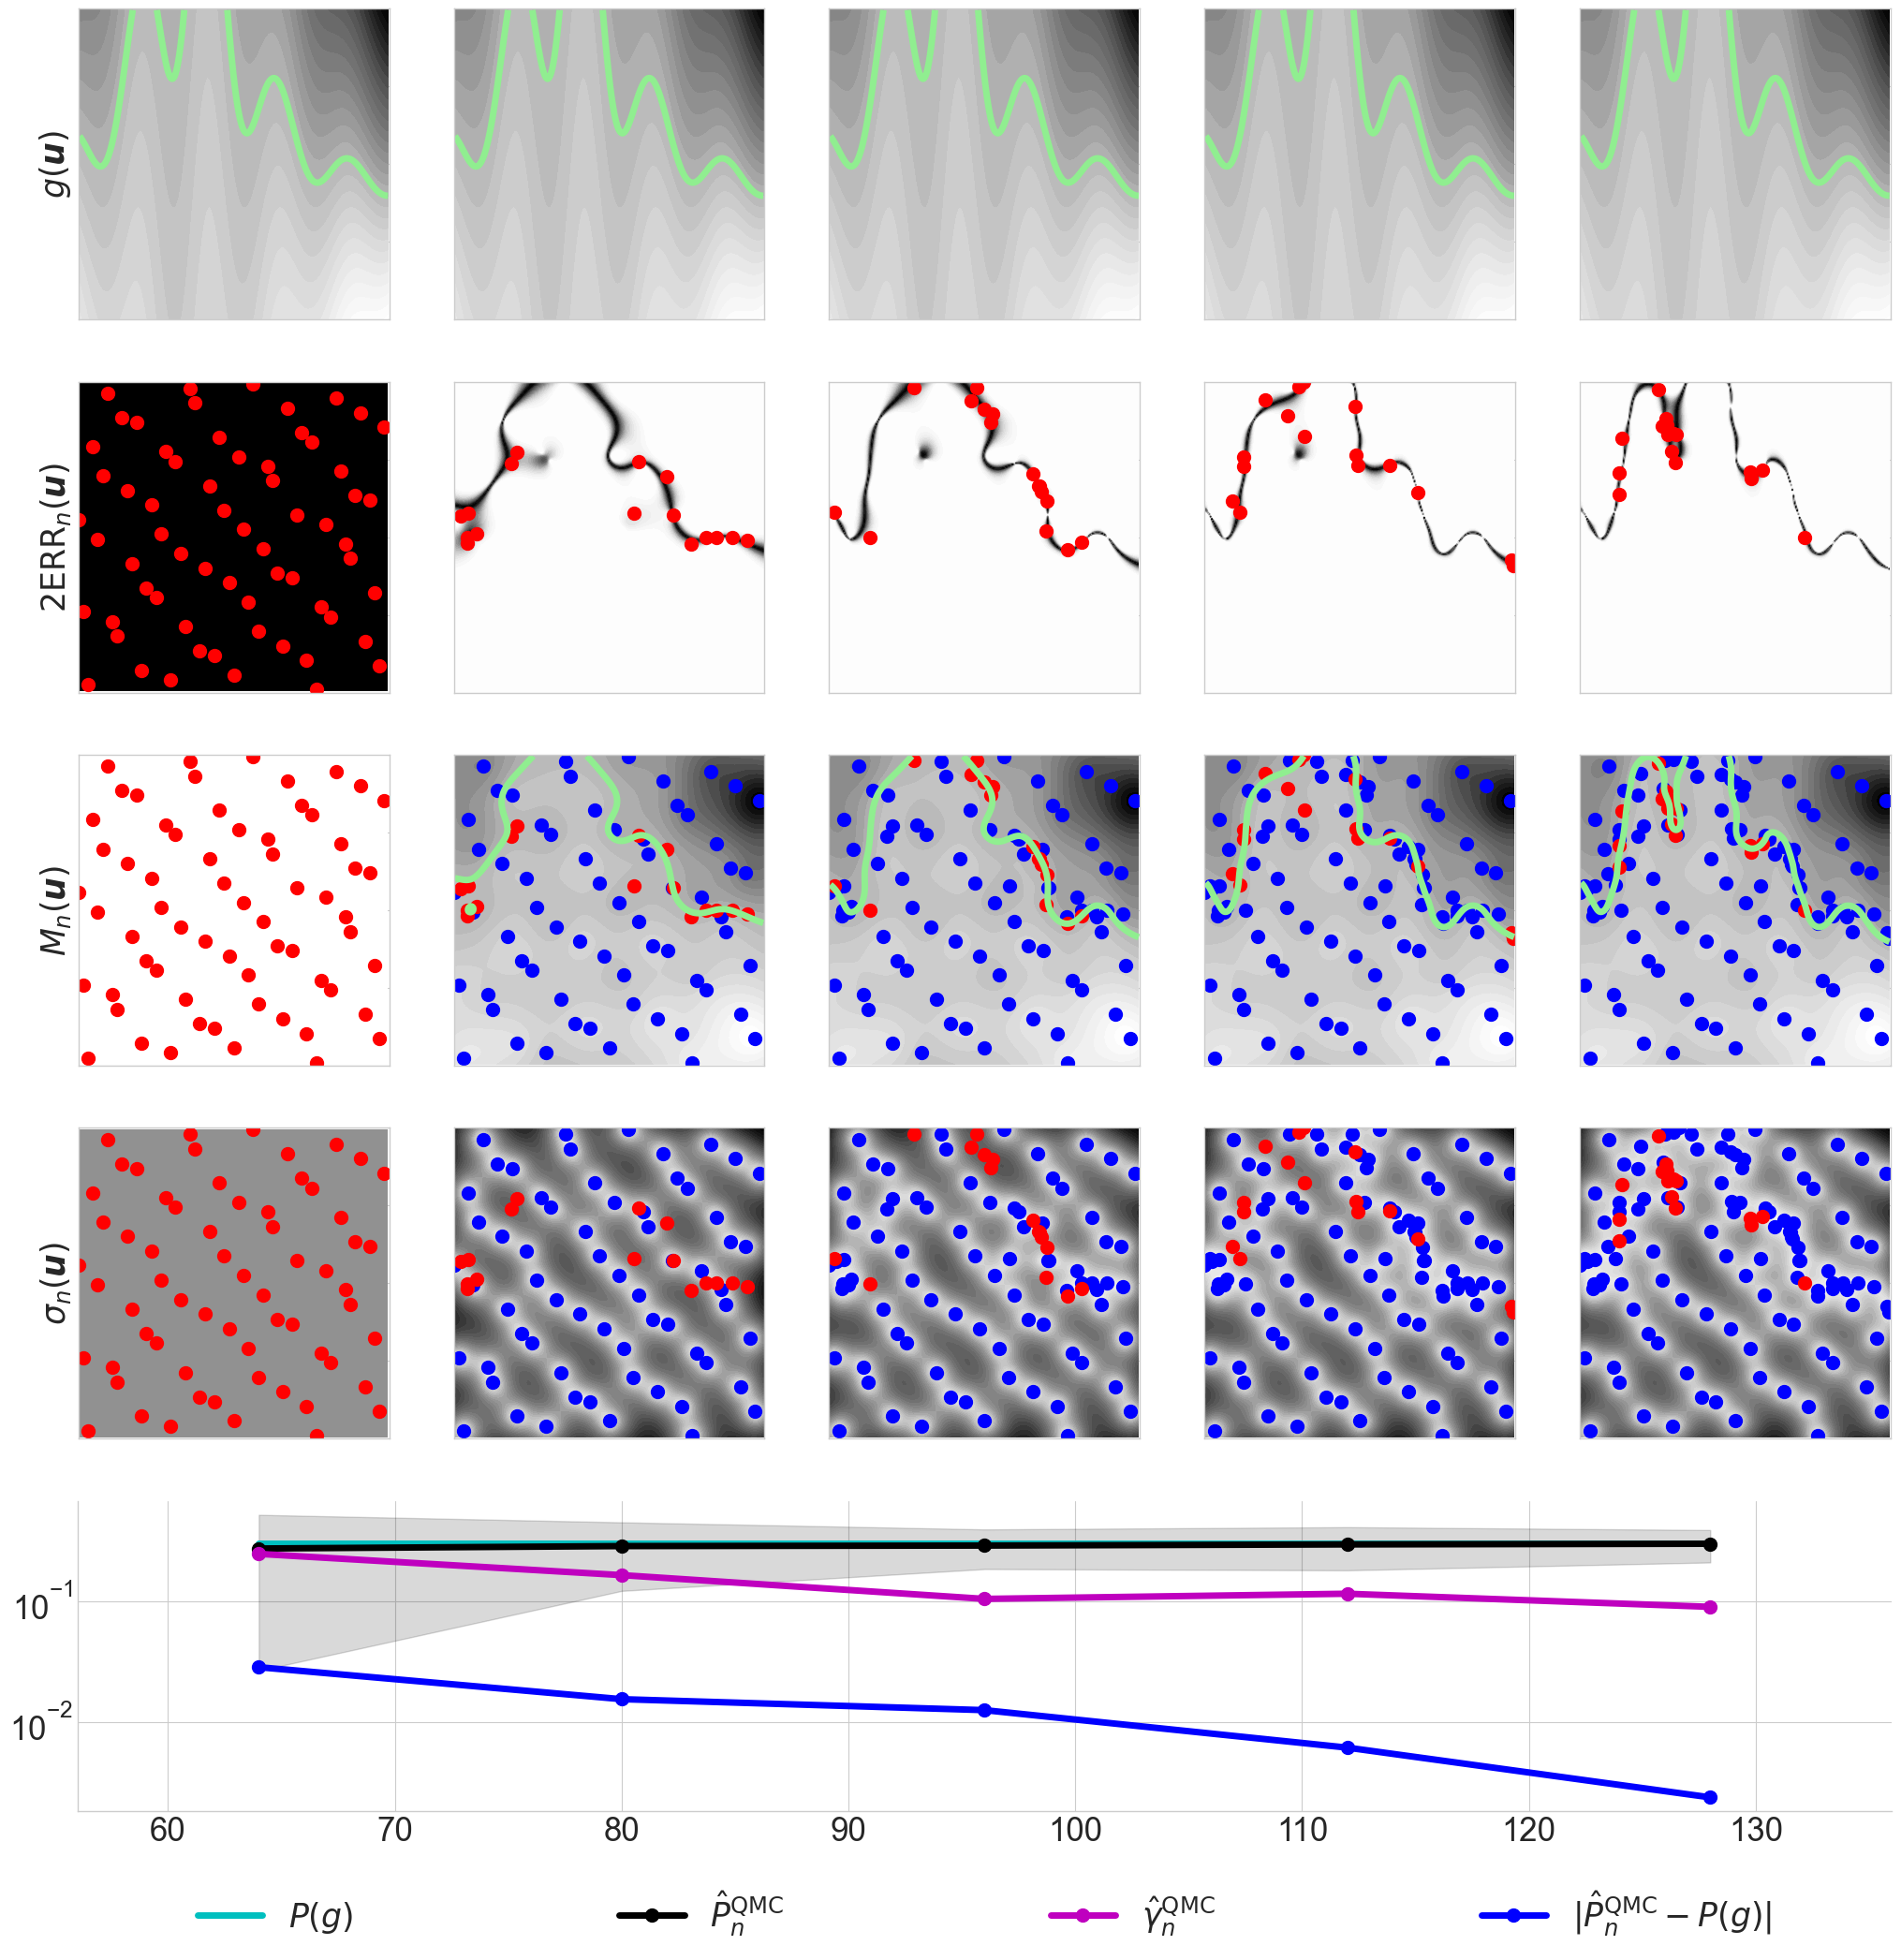

In [5]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Multimodal2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_limit = 128,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.1,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-3,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("outputs/Multimodal2D_df.csv",index=False)
fig.savefig("outputs/Multimodal2D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Four Branch 2d Problem

reference approximation with d=2: 0.20871806144714355
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.88e+00
			covar_module.raw_outputscale...................... 3.85e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.50e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 3.63e+00
			covar_module.raw_outputscale...................... 4.75e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.44e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 4.16e+00
			covar_module.raw_outputscale...................... 5.33e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.04e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 4.58e+00
			covar_module.raw_outputscale...................... 5.77e+00
			covar_module.base_kernel.raw_lengthscale.......... -6.48e+00
batch 1
	AR sampling with efficiency 8.2e-03, expect 1470 draws: 1020, 1360, 1530,

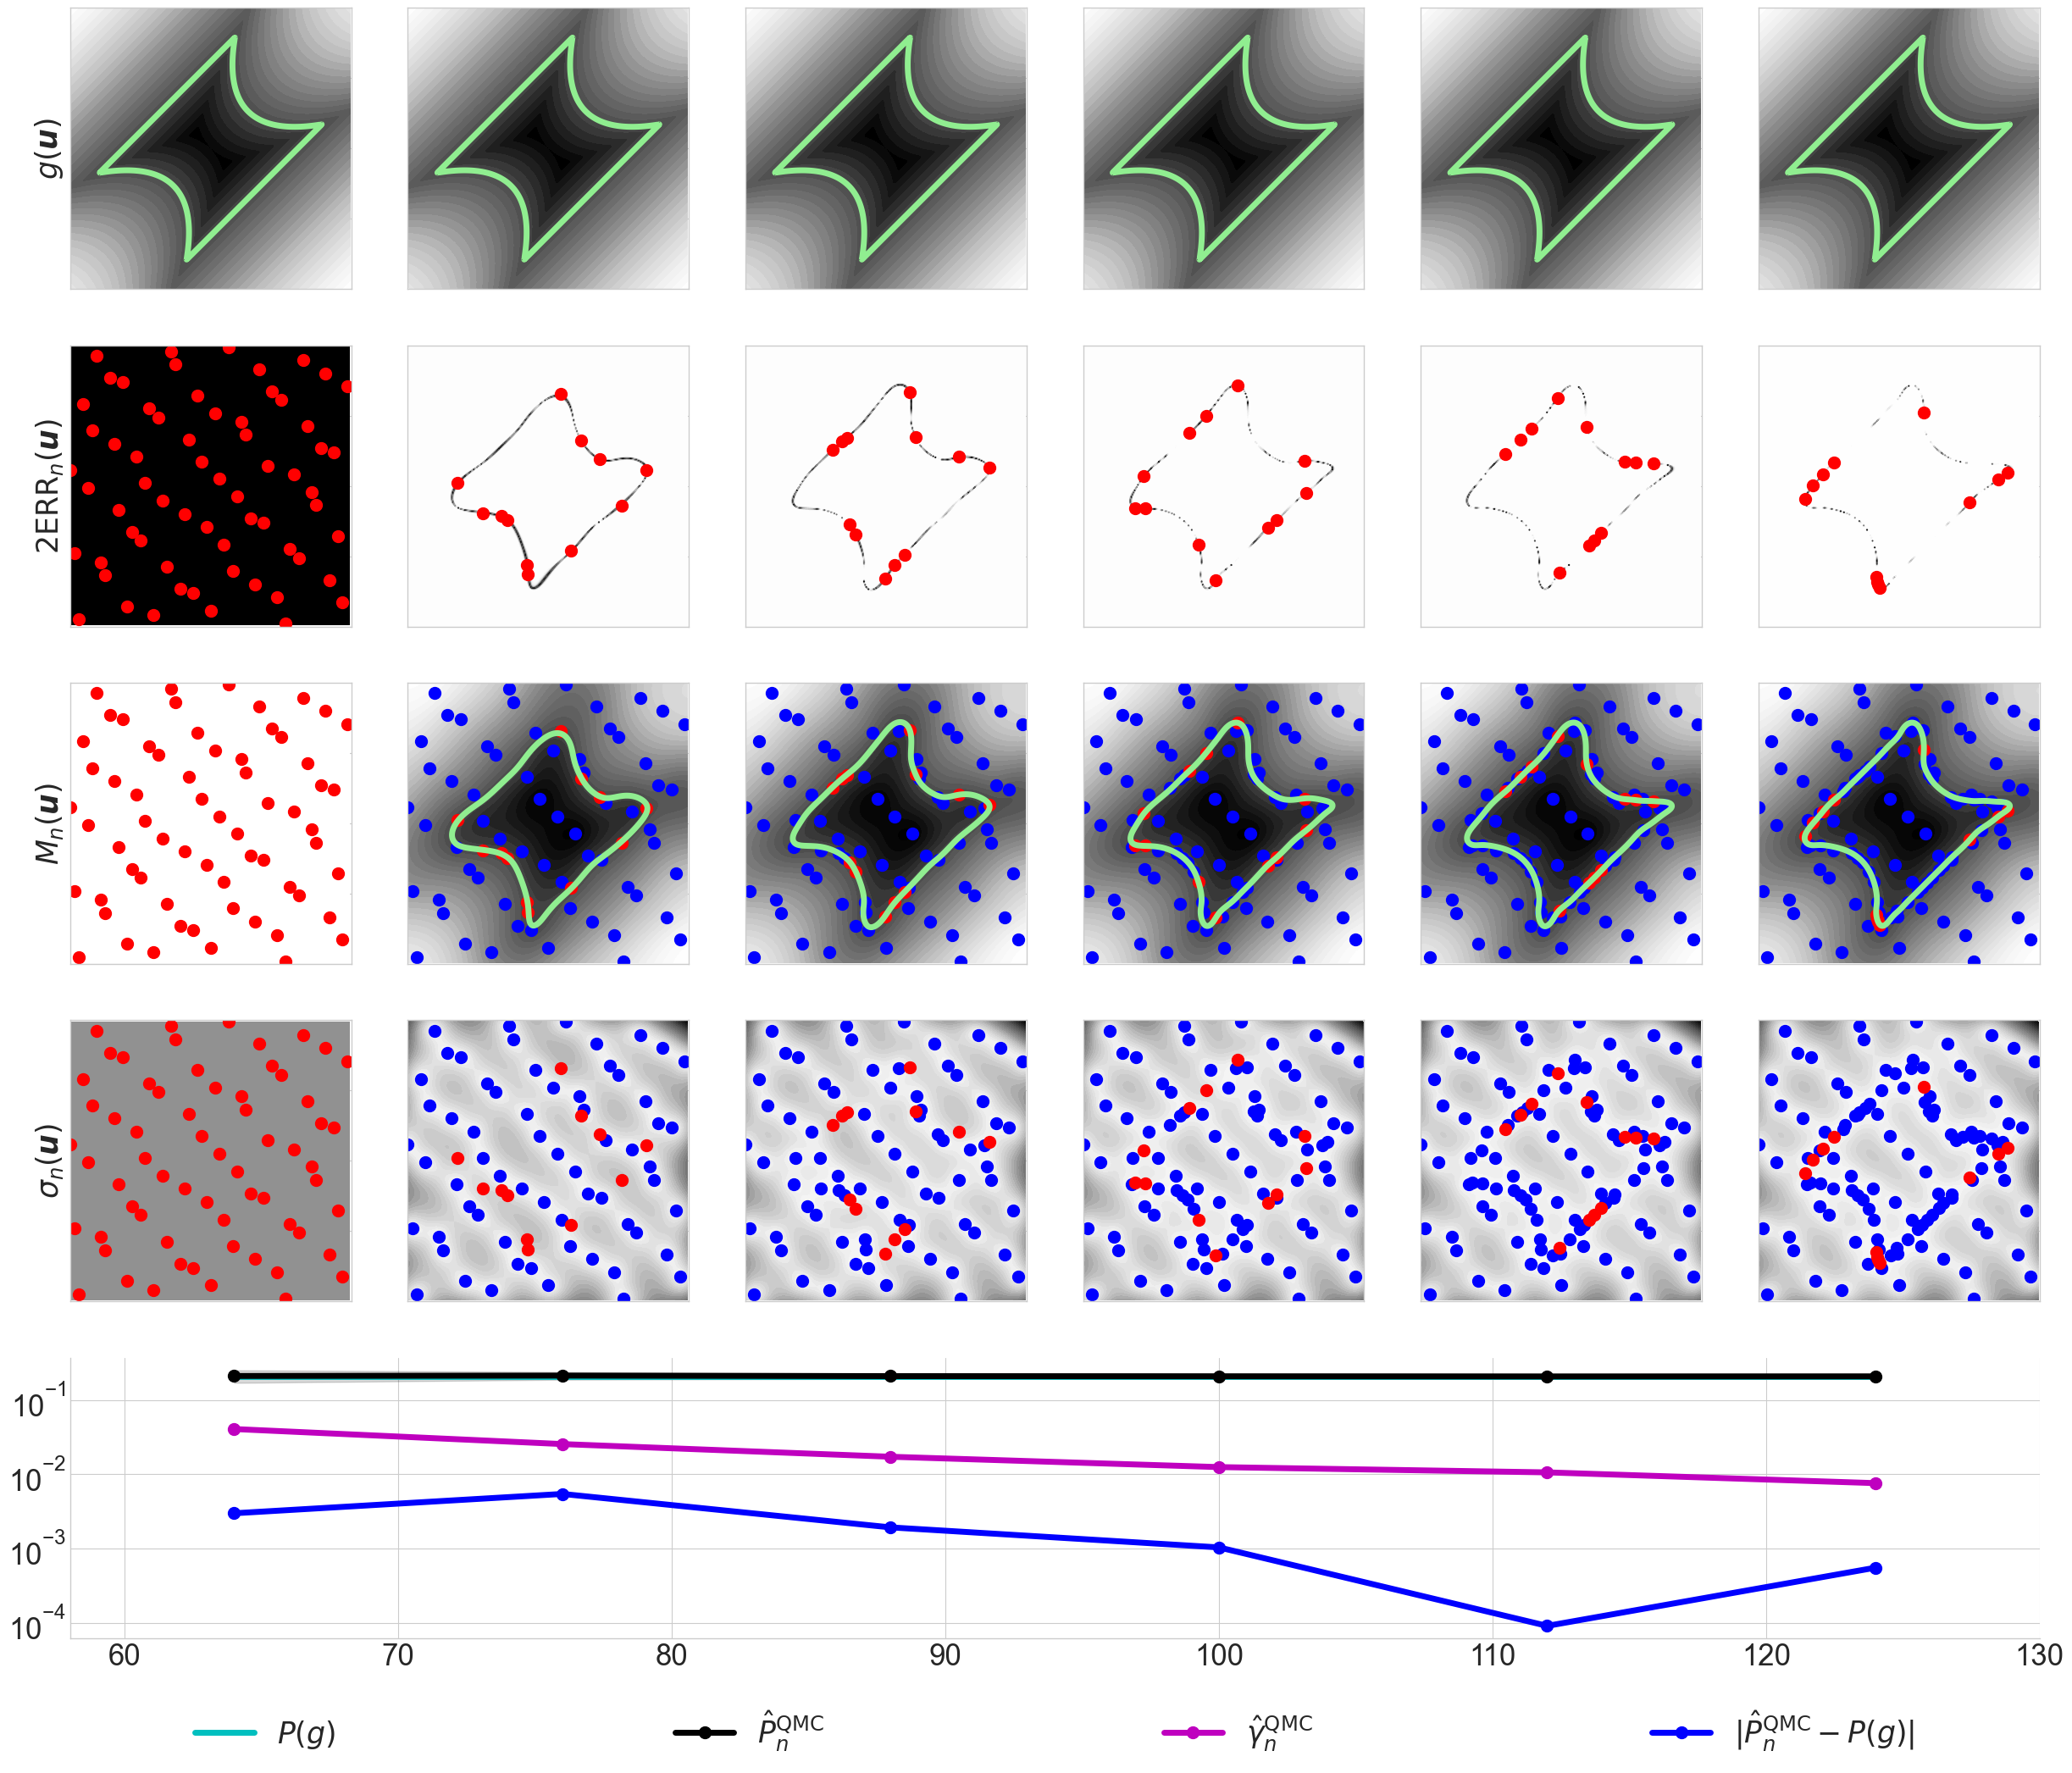

In [6]:
mcispfgp = qp.PFGPCI(
    integrand = qp.FourBranch2d(qp.DigitalNetB2(2,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=True,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 12,
    n_limit = 200,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=1.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
fig = data.plot()
df.to_csv("outputs/FourBranch2D_df.csv",index=False)
fig.savefig("outputs/FourBranch2D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Ishigami 3d Problem

reference approximation with d=3: 0.1623830795288086
batch 0
	gpytorch model fitting
		iter 200 of 800
			likelihood.noise_covar.raw_noise.................. 2.21e+00
			covar_module.raw_outputscale...................... 3.42e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.08e+00
		iter 400 of 800
			likelihood.noise_covar.raw_noise.................. 2.70e+00
			covar_module.raw_outputscale...................... 4.25e+00
			covar_module.base_kernel.raw_lengthscale.......... -4.98e+00
		iter 600 of 800
			likelihood.noise_covar.raw_noise.................. 3.12e+00
			covar_module.raw_outputscale...................... 4.81e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.56e+00
		iter 800 of 800
			likelihood.noise_covar.raw_noise.................. 3.48e+00
			covar_module.raw_outputscale...................... 5.23e+00
			covar_module.base_kernel.raw_lengthscale.......... -5.99e+00
batch 1
	AR sampling with efficiency 6.2e-03, expect 2589 draws: 1792, 2240, 2576, 

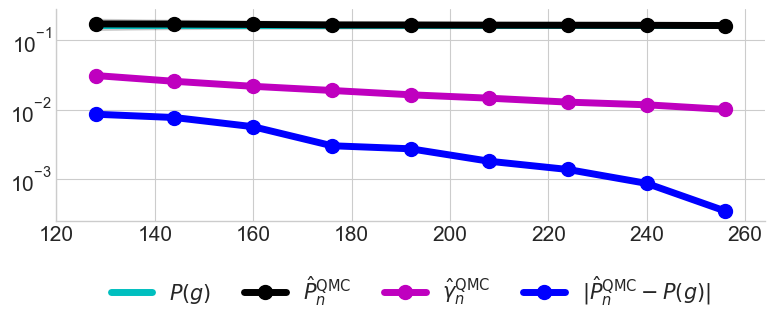

In [16]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Ishigami(qp.DigitalNetB2(3,seed=17)),
    failure_threshold = 0,
    failure_above_threshold=False,
    abs_tol = 1e-2,
    alpha = 1e-1,
    n_init = 128,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 16,
    n_limit = 256,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.5,1)
            ),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,.5)
        ),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 800,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 200,
    n_ref_approx = 2**22,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['legend.fontsize'] = 15
fig = data.plot()
fig.tight_layout()
df.to_csv("outputs/Ishigami3D_df.csv",index=False)
fig.savefig("outputs/Ishigami3D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Hartmann 6d Problem

reference approximation with d=6: 0.007385849952697754
batch 0
	gpytorch model fitting
		iter 50  of 150
			likelihood.noise_covar.raw_noise.................. 1.28e+00
			covar_module.raw_outputscale...................... 5.62e-01
			covar_module.base_kernel.raw_lengthscale.......... 1.90e-01
		iter 100 of 150
			likelihood.noise_covar.raw_noise.................. 2.28e+00
			covar_module.raw_outputscale...................... 5.14e-01
			covar_module.base_kernel.raw_lengthscale.......... 1.83e-01
		iter 150 of 150
			likelihood.noise_covar.raw_noise.................. 2.84e+00
			covar_module.raw_outputscale...................... 5.12e-01
			covar_module.base_kernel.raw_lengthscale.......... 1.83e-01
batch 1
	AR sampling with efficiency 2.5e-03, expect 25281 draws: 17536, 19180, 
batch 2
	AR sampling with efficiency 2.5e-03, expect 25500 draws: 17664, 25944, 27600, 
batch 3
	AR sampling with efficiency 2.0e-03, expect 31766 draws: 22016, 30272, 31992, 33368, 34056, 34744, 35088, 35432, 3

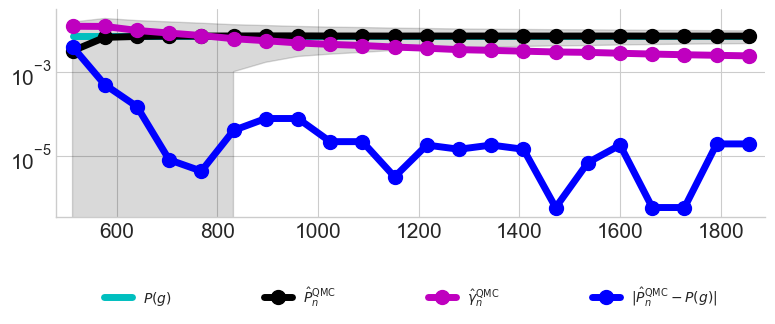

In [ ]:
mcispfgp = qp.PFGPCI(
    integrand = qp.Hartmann6d(qp.DigitalNetB2(6,seed=17)),
    failure_threshold = -2,
    failure_above_threshold=False,
    abs_tol = 2.5e-3,
    alpha = 1e-1,
    n_init = 512,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 64,
    n_limit = 2500,
    n_approx = 2**18,
    gpytorch_prior_mean = gpytorch.means.ZeroMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-8)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 150,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 50,
    n_ref_approx = 2**23,
    seed_ref_approx = None)
solution,data = mcispfgp.integrate(seed=7,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['legend.fontsize'] = 15
fig = data.plot()
fig.tight_layout()
df.to_csv("outputs/Hartmann6D_df.csv",index=False)
fig.savefig("outputs/Hartmann6D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

## Tsunami

In [17]:
import umbridge

In [18]:
!docker run --name tsunami -d -it -p 4242:4242 linusseelinger/model-exahype-tsunami:latest # https://um-bridge-benchmarks.readthedocs.io/en/docs/models/exahype-tsunami.html

Unable to find image 'linusseelinger/model-exahype-tsunami:latest' locally
docker: Error response from daemon: no matching manifest for linux/arm64/v8 in the manifest list entries: no match for platform in manifest: not found

Run 'docker run --help' for more information


In [ ]:
ld_sampler = qp.DigitalNetB2(2,seed=7)
origin_distrib = qp.Uniform(ld_sampler,lower_bound=[-239,-339],upper_bound=[739,339])
umbridge_tsu_model = umbridge.HTTPModel('http://localhost:4242','forward')
umbridge_config = {'d': origin_distrib.d, 'level':1}
qmcpy_umbridge_tsu_model = qp.UMBridgeWrapper(origin_distrib,umbridge_tsu_model,umbridge_config,parallel=True)

In [28]:
class TsunamiMaxWaveHeightBouy1(qp.Integrand):
    # https://um-bridge-benchmarks.readthedocs.io/en/docs/models/exahype-tsunami.html#
    def __init__(self, qmcpy_umbridge_tsu_model):
        self.tsu_model = qmcpy_umbridge_tsu_model
        self.true_measure = self.sampler = self.tsu_model.true_measure
        assert self.tsu_model.d == 2
        super(TsunamiMaxWaveHeightBouy1,self).__init__(
            dimension_indv = (),
            dimension_comb = (),
            parallel = False,
            threadpool = False)
    def g(self, t):
        assert t.ndim==2 and t.shape[1]==self.d
        y = self.tsu_model.g(t)
        y_buoy1_height = 1000*y[1] # max wave height at buoy (meters SSHA)
        height_above_thresh = y_buoy1_height
        return height_above_thresh
tmwhb1 = TsunamiMaxWaveHeightBouy1(qmcpy_umbridge_tsu_model)

batch 0
	gpytorch model fitting
		iter 1000 of 1000
			likelihood.noise_covar.raw_noise.................. 1.17e+00
			mean_module.raw_constant.......................... -2.25e+00
			covar_module.raw_outputscale...................... 1.99e+00
			covar_module.base_kernel.raw_lengthscale.......... -3.02e+00
batch 1
	AR sampling with efficiency 1.9e-02, expect 426 draws: 296, 444, 555, 
batch 2
	AR sampling with efficiency 5.5e-03, expect 1450 draws: 1008, 1512, 1638, 
batch 3
	AR sampling with efficiency 1.1e-02, expect 757 draws: 528, 924, 990, 
batch 4
	AR sampling with efficiency 3.2e-03, expect 2489 draws: 1728, 3024, 
batch 5
	AR sampling with efficiency 2.5e-03, expect 3227 draws: 2240, 2800, 3360, 3640, 
batch 6
	AR sampling with efficiency 1.4e-03, expect 5698 draws: 3952, 
batch 7
	AR sampling with efficiency 1.7e-03, expect 4841 draws: 3360, 3780, 
batch 8
	AR sampling with efficiency 1.6e-03, expect 4905 draws: 3400, 4675, 5100, 
PFGPCIData (Data)
    solution        0.057
    

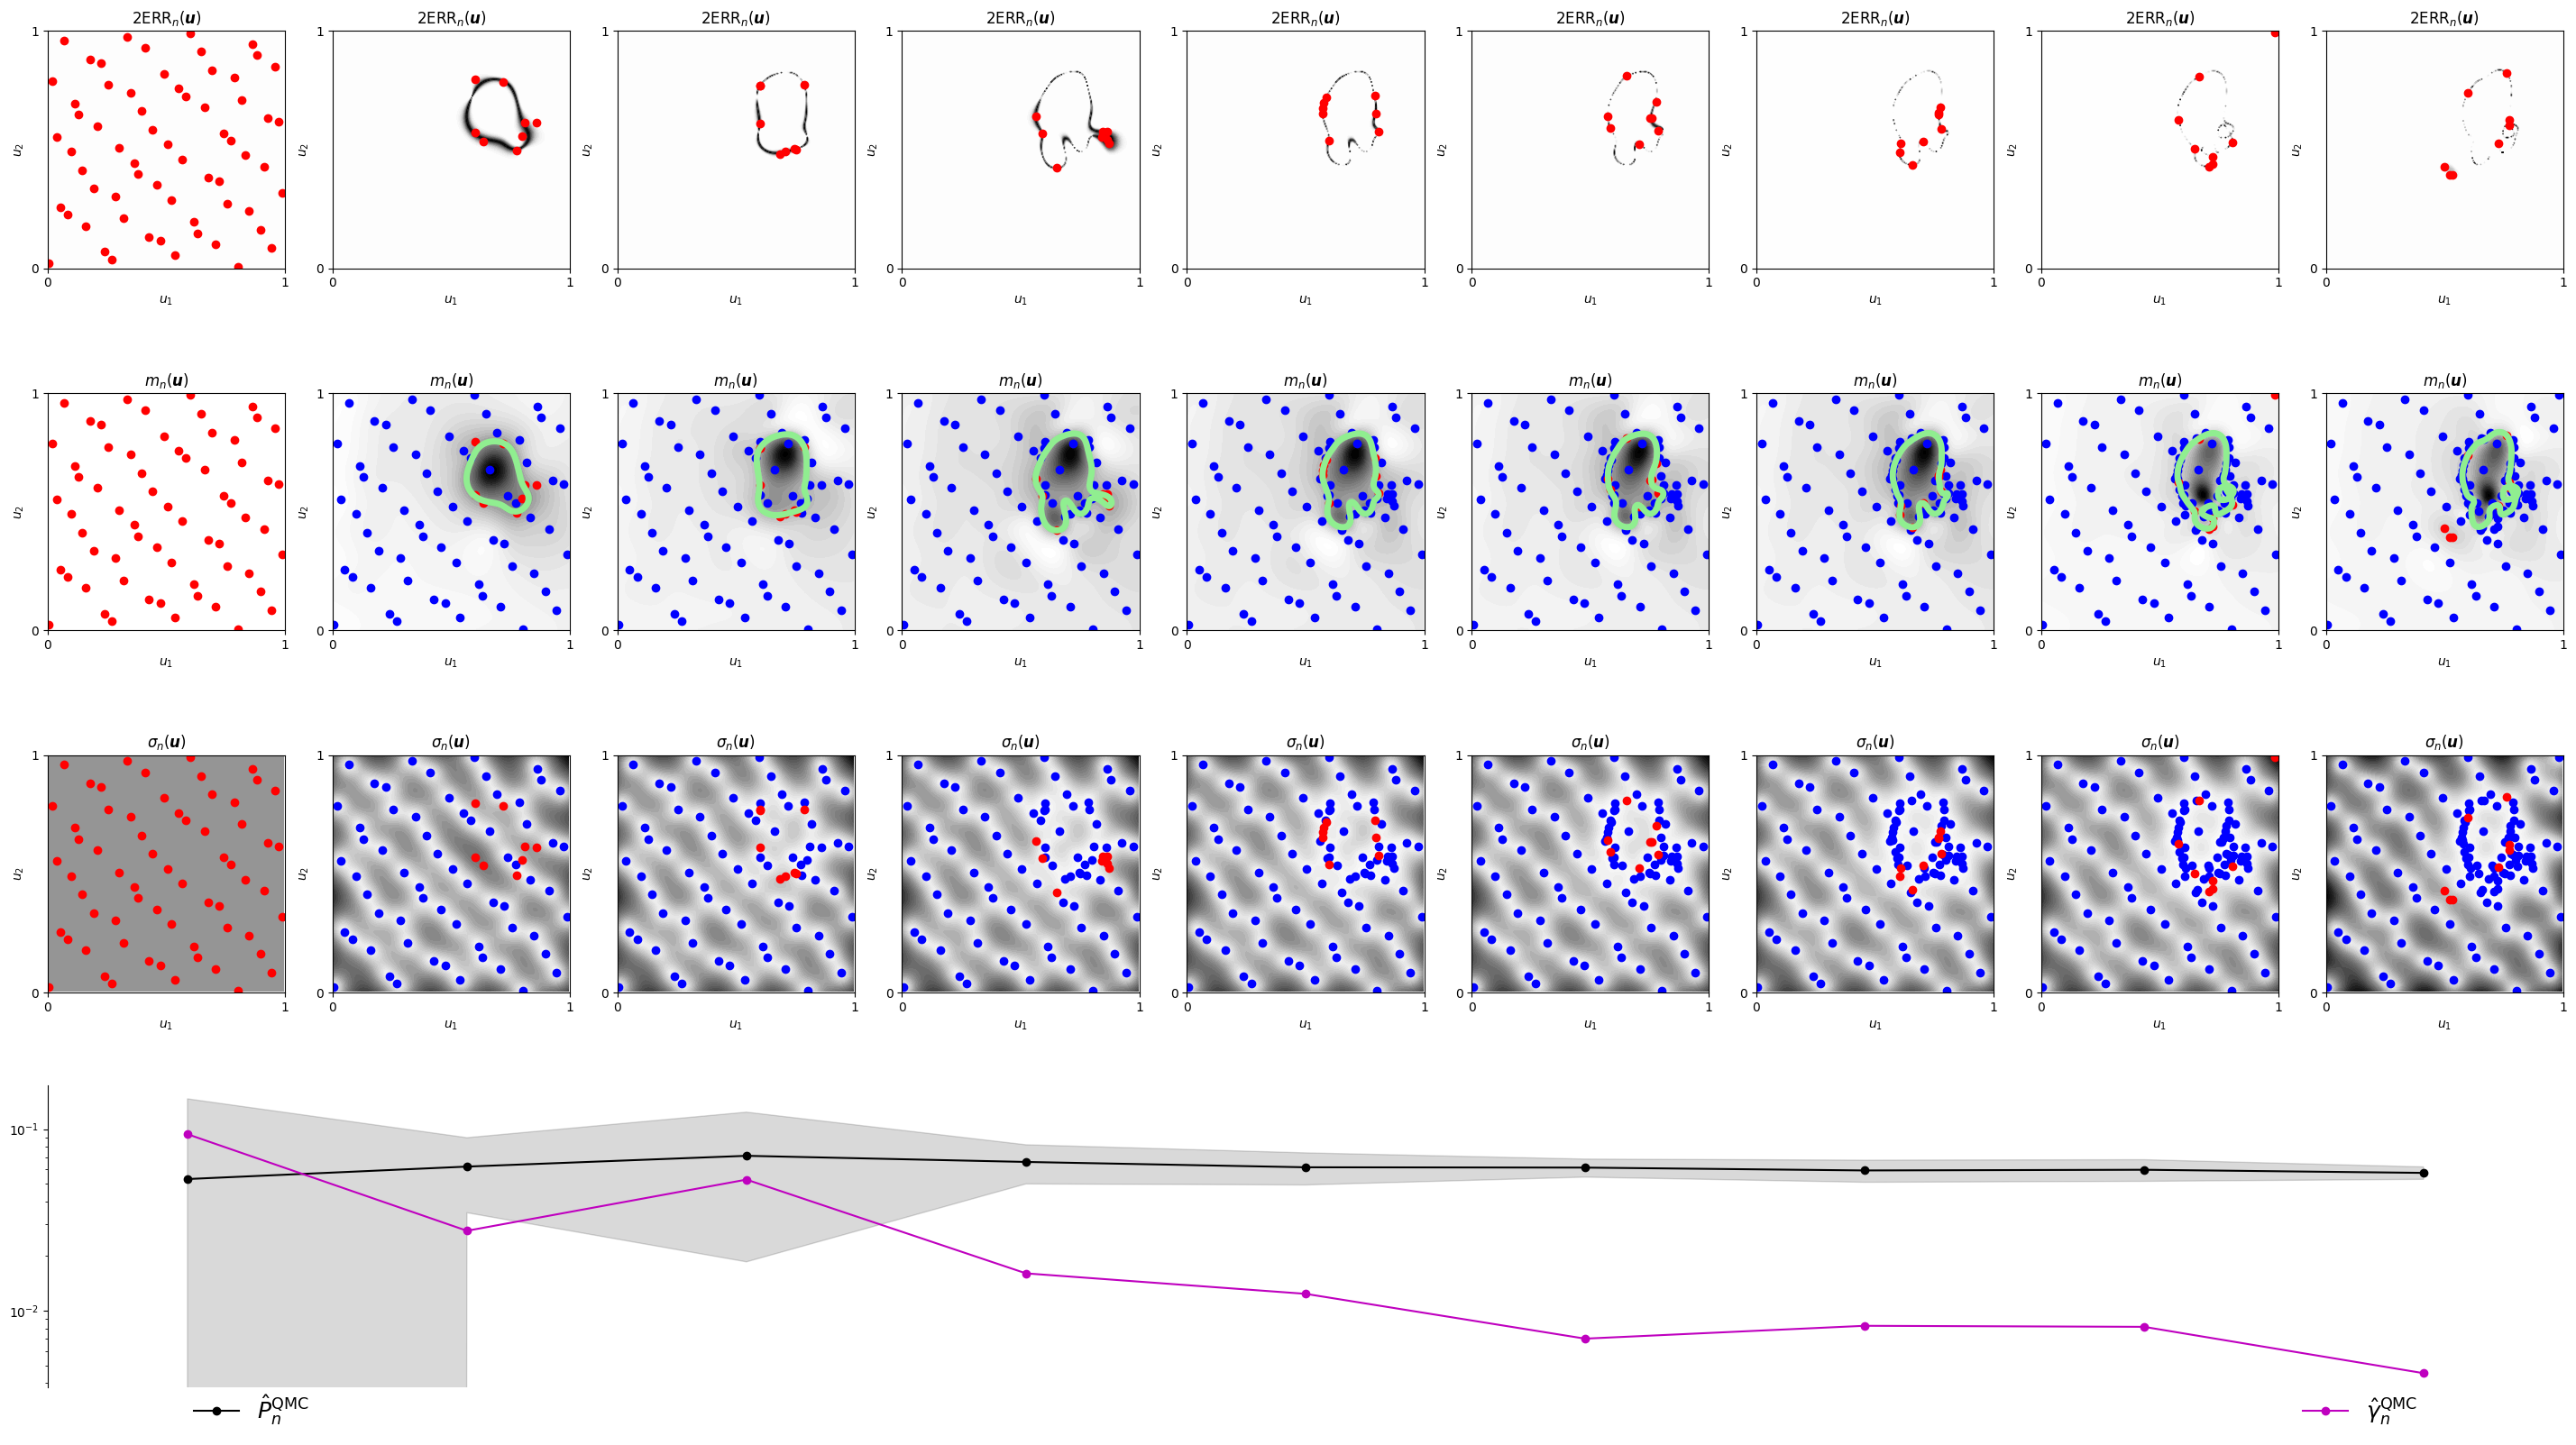

In [ ]:
mcispfgp = qp.PFGPCI(
    integrand = tmwhb1,
    failure_threshold = 3,
    failure_above_threshold=True,
    abs_tol = 1e-3,
    alpha = 1e-1,
    n_init = 64,
    init_samples = None,
    batch_sampler = qp.PFSampleErrorDensityAR(verbose=True),
    n_batch = 8,
    n_limit = 128,
    n_approx = 2**20,
    gpytorch_prior_mean = gpytorch.means.ConstantMean(),
    gpytorch_prior_cov = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.MaternKernel(nu=2.5,
            lengthscale_constraint = gpytorch.constraints.Interval(.1,1)),
        outputscale_constraint = gpytorch.constraints.Interval(1e-8,1)),
    gpytorch_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = gpytorch.constraints.Interval(1e-12,1e-10)),
    gpytorch_marginal_log_likelihood_func = lambda likelihood,gpyt_model: gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpyt_model),
    torch_optimizer_func = lambda gpyt_model: torch.optim.Adam(gpyt_model.parameters(),lr=0.1),
    gpytorch_train_iter = 1000,
    gpytorch_use_gpu = gpytorch_use_gpu,
    verbose = 1000,
    n_ref_approx = 0)
solution,data = mcispfgp.integrate(seed=11,refit=False)
print(data)
df = pd.DataFrame(data.get_results_dict())
print("\nIteration Summary")
print(df)
pyplot.rcParams['font.size'] = 25
pyplot.rcParams['legend.fontsize'] = 25
fig = data.plot()
df.to_csv("outputs/Tsunami2D_df.csv",index=False)
fig.savefig("outputs/Tsunami2D_fig.png",dpi=256,transparent=True,bbox_inches="tight")

In [30]:
!docker rm -f tsunami

python(15698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


tsunami
